# FINAL PROJECT: NN MODEL ALONE

You can find all the data in `../readonly/final_project_data` folder or download it from [Kaggle](https://inclass.kaggle.com/c/competitive-data-science-final-project) if you are solving locally. 

**Good luck!**

# Competition description

This challenge serves as final project for the _"How to win a data science competition"_ Coursera course.

In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - __1C Company__.

We are asking you to __predict total sales for every product and store in the next month__. By solving this competition you will be able to apply and enhance your data science skills.

### Submission File

For each id in the test set, you must predict a total number of sales. The file should contain a header and have the following format:

`ID,item_cnt_month
0,0.5
1,0.5
2,0.5
3,0.5
etc.`

### Team Limits

Three individuals.

### Submission Limits

You may submit a maximum of 5 entries per day (10 for Coursera).

### Metric

Submissions are evaluated by root mean squared error (__RMSE__). True target values are clipped into [0,20] range.

In [1]:
target_range = [0, 20]

### Leaderboard
By now lowest RMSE in PL is: `0.79215`
with `210` submissions

# Imports

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, HTML

import os, gc, math, time, datetime

import pandas as pd
import numpy as np

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline 

from itertools import product
import scipy

from tqdm import tqdm, tqdm_notebook
tqdm.monitor_interval = 0

import data
from data import index_cols, index_cols_shop, future_index_cols
import features
import tools
from tools import now
import models

%load_ext autoreload
%autoreload 2

In [3]:
import sklearn
for p in [np, pd, sklearn, scipy, torch]:
    print (p.__name__, p.__version__)

numpy 1.17.0
pandas 0.25.0
sklearn 0.21.3
scipy 1.3.0
torch 1.1.0


# Load features

Preprocessed, from disk.

In [4]:
all_data = features.load_features()

In [5]:
# Check
data.inspect_dataframe('ALL_DATA', all_data)


ALL_DATA (6639294, 44)
shop_id                       int32
item_id                       int32
date_block_num                int32
target                      float32
revenue                     float32
target_shop                 float32
revenue_per_shop            float32
target_item                 float32
revenue_per_item            float32
item_category_id              int32
target_category             float32
revenue_per_category        float32
target_item_price           float32
item_category_id_enc        float32
target_lag_1                float32
target_lag_2                float32
target_lag_3                float32
target_lag_4                float32
target_lag_5                float32
target_lag_12               float32
target_shop_lag_1           float32
target_shop_lag_2           float32
target_shop_lag_3           float32
target_shop_lag_4           float32
target_shop_lag_5           float32
target_shop_lag_12          float32
target_item_lag_1           float32
targ

,shop_id,item_id,date_block_num,target,revenue,target_shop,revenue_per_shop,target_item,revenue_per_item,item_category_id,...,target_category_lag_3,target_category_lag_4,target_category_lag_5,target_category_lag_12,target_item_price_lag_1,target_item_price_lag_2,target_item_price_lag_3,target_item_price_lag_4,target_item_price_lag_5,target_item_price_lag_12
4488756,2,27,12,0.0,0.0,890.0,1032722.0,1.0,998.0,19,...,14113.0,18932.0,10488.0,8983.0,1048.000000,1198.000000,942.266663,1198.0,1198.000000,2325.0
4488757,2,30,12,0.0,0.0,890.0,1032722.0,58.0,9802.0,40,...,24173.0,23348.0,24130.0,0.0,167.330856,165.217392,205.524994,399.0,384.894745,0.0
4488758,2,31,12,0.0,0.0,890.0,1032722.0,15.0,7485.0,37,...,6950.0,7659.0,8680.0,0.0,499.000000,488.377777,543.528015,699.0,688.400024,0.0


,shop_id,item_id,date_block_num,target,revenue,target_shop,revenue_per_shop,target_item,revenue_per_item,item_category_id,...,target_category_lag_3,target_category_lag_4,target_category_lag_5,target_category_lag_12,target_item_price_lag_1,target_item_price_lag_2,target_item_price_lag_3,target_item_price_lag_4,target_item_price_lag_5,target_item_price_lag_12
11128047,59,22164,34,0.0,0.0,0.0,0.0,0.0,0.0,37,...,3426.0,3291.0,3756.0,0.0,549.000000,549.0,631.5,699.0,699.000000,0.0
11128048,59,22166,34,0.0,0.0,0.0,0.0,0.0,0.0,54,...,264.0,276.0,292.0,305.0,150.000000,150.0,150.0,150.0,150.000000,150.0
11128049,59,22167,34,0.0,0.0,0.0,0.0,0.0,0.0,49,...,571.0,669.0,699.0,760.0,293.895935,299.0,299.0,299.0,294.636353,299.0


# Data split

The dataset has a timeline, get last month of train as validation data.

And the month=34 is the X_test for final submission.

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = data.split(all_data)

Test data is where date_block_num=34
Validation data is where date_block_num=33

fit_cols: ['item_category_id', 'item_category_id_enc', 'target_lag_1', 'target_lag_2', 'target_lag_3', 'target_lag_4', 'target_lag_5', 'target_lag_12', 'target_shop_lag_1', 'target_shop_lag_2', 'target_shop_lag_3', 'target_shop_lag_4', 'target_shop_lag_5', 'target_shop_lag_12', 'target_item_lag_1', 'target_item_lag_2', 'target_item_lag_3', 'target_item_lag_4', 'target_item_lag_5', 'target_item_lag_12', 'target_category_lag_1', 'target_category_lag_2', 'target_category_lag_3', 'target_category_lag_4', 'target_category_lag_5', 'target_category_lag_12', 'target_item_price_lag_1', 'target_item_price_lag_2', 'target_item_price_lag_3', 'target_item_price_lag_4', 'target_item_price_lag_5', 'target_item_price_lag_12'] 32 

train validation test total
6186922 238172 214200 6639294
6186922 238172 214200 6639294


# MODEL
Use the pre-tuned NN model.

In [7]:
# Fit
nn_model = models.modelNNR(target_range)
nn_model.fit_early(X_train,y_train,X_val,y_val)

model in GPU
model in GPU
{'num_feat': 32, 'n_hidden1': 200, 'n_hidden2': 100, 'dropout': 0.2, 'optim_type': 'adam', 'learning_rate': 0.0001, 'batch_size': 1024}
2019-08-07 11:48:23.551701
 ** predictions clipping to [0, 20]
 ** predictions clipping to [0, 20]

2019-08-07 11:48:26 ---- START training
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
2019-08-07 12:26:23 *** Early stop at epoch 45/99, best_ValLoss = 0.9156
2019-08-07 12:26:23 --- DONE Epoch = 45/99 AvgLoss = 0.8175 ValLoss = 0.9180

elapsed training time: 2280.49


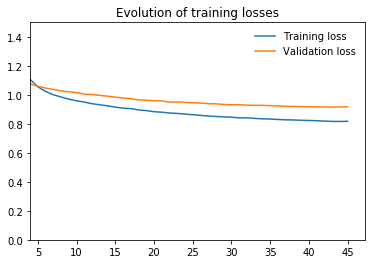

(0, 1.5)

In [8]:
nn_model.model.plot_training_evolution(loss_limit=1.5)

In [9]:
# Score
nn_model.scoring(X_val, y_val)

 ** predictions clipping to [0, 20]
elapsed infer time: 0.16
 ** predictions clipping to [0, 20]
Dev RMSE for NNR is 0.956007


In [10]:
# Predictions
submission_preds = nn_model.predict(X_test)

 ** predictions clipping to [0, 20]
elapsed infer time: 0.14


# SUBMISSION

In [11]:
#Load test data to merge ID for submission

#DATA_FOLDER = "../input" # en kernel de kaggle
#DATA_FOLDER = "../readonly/final_project_data" # en coursera
DATA_FOLDER = "./data"
#print(os.listdir(DATA_FOLDER))

test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))

In [12]:
# Create submission dataframe
submission = data.create_submission_dataframe(submission_preds, all_data, test)

Test data is where date_block_num=34
214200 214200 0.31411067 0.26927617
214200 214200 0.26927617 0.26927617


In [13]:
# Dump to file
submission_columns = ['ID','item_cnt_month']
submission_filename = './submissions/submission_nn_alone.csv'
submission[submission_columns].to_csv(submission_filename,header=True,index=False)

In [14]:
tools.head_and_tail_file(submission_filename,N=3)

ID,item_cnt_month

0,0.35071987

1,0.13276136

2,0.7605034

[...]

214197,0.04536949

214198,0.028960612

214199,0.057693712

TOTAL lines: 214201 ( 214201 )


In [15]:
# SUBMISSION RESULT (PASSED)
# grade: 8/10
# Your public and private LB scores are: 0.998695 and 0.999005.

# Future work

Because of a lack of time I have left behind some aspects that could improve the solution:

* Better tuning of NN or more complexity (LSTM, GRU)
* Use text data, encoded as n-grams or TF-IDF (more advanced, pretrained word2vec for russian language)
* Include KNN features
* Ensemble or stacking of models